# Поиск координат углов прямоугольника на изображении

# Описание задачи.

**Реализовать модуль генерации данных**


Реализовать на языке Python класс, один из методов которого будет создавать изображение и описание фигур, находящихся на этом изображении. Сгенерированное изображение должно быть размером 640х480 пикселей и представляет собой однотонный фон случайного цвета, на котором размещен прямоугольник случайного размера (без выхода за границы изображения) со стороной от 150 до 250 пикселей случайного цвета, отличного от цвета фона, повернутого на случайный угол от 0 до 89 градусов.
Выход метода класса:

- сгенерированное изображение;
- параметры описывающего прямоугольника (координаты x, y верхнего левого угла, ширина (w) и высота (h));
- координаты четырех углов сгенерированного прямоугольника.


**Поиск координат углов прямоугольника на изображении**

Реализовать нейронную сеть, которая осуществляет поиск координат углов прямоугольников на изображении. В качестве обучающих и тестовых данных использовать ваш класс из п.1. Выходом обученной нейронной сети являются координаты 4 углов прямоугольника на изображении. Привести график функции потерь (loss function) в ходе обучения. Привести максимальное, минимальное и среднее значение L2 метрики (евклидово расстояние) для тестовой выборки из 1000 примеров для 2 разных checkpoint-ов обучения (промежуточного и финального).


In [1]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow as tf
import pandas as pd
from random import randint
import math
from sklearn.model_selection import train_test_split
from PIL import Image
import shutil
import os

# Создание класса, генерирующего прямоугольники.

Создадим класс генирирующий случайные прямоугольники. Он будет сохранять изображения и записывать csv файл с координатами углов прямоугольников в нужную директори. В этой задаче описывающий прямоугольник не используется, поэтому его параметры возвращать не будем. Параметры описывающего прямоугольника используются в задаче с YOLO.

In [2]:
class Rectangles():

    def __init__(self,w_min,w_max,h_min,theta_min,theta_max):
        self.w_min = w_min
        self.w_max = w_max
        self.h_min = h_min
        self.theta_min = theta_min
        self.theta_max = theta_max


    def rectangle(self):
        w = randint(self.w_min,self.w_max)
        h = randint(self.h_min,w-1)
        xc = randint(0,640)
        yc=randint(0,480)
        theta = randint(self.theta_min,self.theta_max)
        r_color = np.random.rand(4)
        b_color = np.random.rand(4)

        rect_0 = np.array([[-w/2, w/2, w/2, -w/2],
                     [h/2, h/2, -h/2, -h/2]])

        r_matrix = np.array([[np.cos(np.radians(theta)),np.sin(np.radians(theta))],
                       [-np.sin(np.radians(theta)),np.cos(np.radians(theta))]])

        rect_1=r_matrix @ rect_0 + np.array([[xc],[yc]])
        if np.min(rect_1[0])<0:
            rect_1[0]= rect_1[0]-np.min(rect_1[0])+10
        if np.min(rect_1[1])<0:
            rect_1[1]= rect_1[1]-np.min(rect_1[1]-5)+10
        if np.max(rect_1[0]>640):
            rect_1[0]=rect_1[0]-(np.max(rect_1[0])-640)-10
        if np.max(rect_1[1]>480):
            rect_1[1]=rect_1[1]-(np.max(rect_1[1])-480)-10
        return rect_1, r_color, b_color
  
    def save_plot(self, n_files, path = 'rectangles/'):
        self.n_files=n_files
        self.path = path
        file_name = []
        coord = []
        for i in range(1,self.n_files+1):
            fig =plt.figure(figsize=(6.40, 4.80),dpi=100)
            ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
            rect_1, r_color, b_color = self.rectangle()
            coord.append(list(rect_1.reshape(1,8)[0]))
            plt.fill(rect_1[0],rect_1[1],color=r_color)
            plt.xticks([])
            plt.yticks([])
            plt.xlim(0,640)
            plt.ylim(0,480)
            zeros_in_name = '0'*(len(str(self.n_files))-len(str(i)))
            file_name.append(f'{zeros_in_name}{i}.png')
            plt.savefig(f'{self.path}\\{zeros_in_name}{i}.png',facecolor=b_color)
            plt.close()
        self.coordinates = pd.DataFrame(coord,columns=['x1','x2','x3','x4','y1','y2','y3','y4'])
        self.coordinates['file_name'] = file_name
        self.coordinates.to_csv('rect_coordinates.csv')

Запустим этот класс

In [3]:
rect= Rectangles(150,250,50,0,89)
rect.save_plot(50000)
#labels = rect.coordinates
labels = pd.read_csv('rect_coordinates.csv',index_col=0)
labels.head()

,x1,x2,x3,x4,y1,y2,y3,y4,file_name
0,552.251721,580.566359,485.748279,457.433641,470.000000,291.228410,276.210702,454.982291,00001.png
1,537.846778,630.000000,444.563229,352.410007,318.008547,89.921319,15.000000,243.087228,00002.png
2,248.044487,398.395306,367.955513,217.604694,411.177933,356.454710,272.822067,327.545290,00003.png
3,404.354272,630.000000,566.955820,341.310092,457.031748,356.567798,214.968252,315.432202,00004.png
4,321.326331,361.485366,224.673669,184.514634,309.590039,148.520948,114.409961,275.479052,00005.png


# Поиск координат углов прямоугольников на изображениях.

В Яндекс практикуме нам сказали, что, если мы когда-нибудь столкнемся с задачами компьютерного зрения, то ResNet50 решит все наши прблемы, поэтому будем использовать ResNet50.

Разделим файлы на обучающую и тестовую выборки.

In [4]:
labels_train, labels_test = train_test_split(labels, test_size=0.2, random_state=42)

Создадим директории для обучающей и тестовой выборок и скопируем туда файлы.

In [5]:
os.mkdir('rectangles/test')
os.mkdir('rectangles/train')

In [6]:
for file in labels_test['file_name']:
    shutil.move(f'rectangles/{file}',f'rectangles/test/{file}')
for file in labels_train['file_name']:
    shutil.move(f'rectangles/{file}',f'rectangles/train/{file}')

Подготовим наборы данных для обучения ResNet50.

In [15]:
train_datagen = ImageDataGenerator(validation_split=0.2,rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_train,
        directory='rectangles/train/',
        x_col='file_name',
        y_col=['x1','x2','x3','x4','y1','y2','y3','y4'],
        target_size=(480, 640),
        batch_size=4,
        class_mode='raw',
        subset='training',
        seed=42) 

Found 32000 validated image filenames.


In [16]:
valid_datagen = ImageDataGenerator(validation_split=0.2,rescale=1./255)
valid_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels_train,
        directory='rectangles/train/',
        x_col='file_name',
        y_col=['x1','x2','x3','x4','y1','y2','y3','y4'],
        target_size=(480, 640),
        batch_size=4,
        class_mode='raw',
        subset='validation',
        seed=42) 

Found 8000 validated image filenames.


В качестве функции потерь и метрики будем использовать евклидово расстояние.

In [17]:
def custom_euclidean(y_true, y_pred):
    return tf.norm(y_true-y_pred,ord='euclidean')

Будем сохранять чекпоинты, которые лучше предыдущих, для этого поставим 
``` python 
save_best_only=True
```
Чтобы они не перезаписывались, а каждый раз сохранялась версия чекпоинта в новую директорию с номером эпохи, добавим 
``` python 
_{epoch}
```
в название директории для сохранения чекпоинтов.

In [18]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = "checkpoints/resnet50_{epoch}",
    save_best_only=True)

#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

Для прогноза координат четырех углов прямоугольника добавим в последний слой 8 нейронов, по два на каждую вершину (x и y) с функцией активации RelU.

In [19]:
backbone = ResNet50(input_shape=(480, 640, 3),
                    weights='imagenet', 
                    include_top=False)
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(8, activation='relu')) 
optimizer = Adam(learning_rate=0.001) 

model.compile(loss=custom_euclidean, 
              optimizer= optimizer, 
              metrics=[custom_euclidean])

In [20]:
history = model.fit(train_gen_flow, 
              validation_data=valid_gen_flow,
              batch_size=2, 
              epochs=25,
              verbose=2, 
              callbacks=[model_checkpoint_callback],
              shuffle=True)

Epoch 1/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_1\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_1\assets


8000/8000 - 2452s - loss: 524.1779 - custom_euclidean: 524.1779 - val_loss: 508.2672 - val_custom_euclidean: 508.2672 - 2452s/epoch - 306ms/step
Epoch 2/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_2\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_2\assets


8000/8000 - 2458s - loss: 120.3792 - custom_euclidean: 120.3792 - val_loss: 485.6766 - val_custom_euclidean: 485.6766 - 2458s/epoch - 307ms/step
Epoch 3/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_3\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_3\assets


8000/8000 - 2454s - loss: 67.3710 - custom_euclidean: 67.3710 - val_loss: 325.5558 - val_custom_euclidean: 325.5558 - 2454s/epoch - 307ms/step
Epoch 4/25
8000/8000 - 2435s - loss: 50.2008 - custom_euclidean: 50.2008 - val_loss: 359.0254 - val_custom_euclidean: 359.0254 - 2435s/epoch - 304ms/step
Epoch 5/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_5\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_5\assets


8000/8000 - 2457s - loss: 39.7632 - custom_euclidean: 39.7632 - val_loss: 276.3667 - val_custom_euclidean: 276.3667 - 2457s/epoch - 307ms/step
Epoch 6/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_6\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_6\assets


8000/8000 - 2452s - loss: 33.0391 - custom_euclidean: 33.0391 - val_loss: 149.7999 - val_custom_euclidean: 149.7999 - 2452s/epoch - 307ms/step
Epoch 7/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_7\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_7\assets


8000/8000 - 2452s - loss: 29.5853 - custom_euclidean: 29.5853 - val_loss: 117.1516 - val_custom_euclidean: 117.1516 - 2452s/epoch - 307ms/step
Epoch 8/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_8\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_8\assets


8000/8000 - 2452s - loss: 26.2721 - custom_euclidean: 26.2721 - val_loss: 26.9146 - val_custom_euclidean: 26.9146 - 2452s/epoch - 306ms/step
Epoch 9/25
8000/8000 - 2434s - loss: 24.9631 - custom_euclidean: 24.9631 - val_loss: 65.4707 - val_custom_euclidean: 65.4707 - 2434s/epoch - 304ms/step
Epoch 10/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_10\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_10\assets


8000/8000 - 2456s - loss: 22.6557 - custom_euclidean: 22.6557 - val_loss: 24.6405 - val_custom_euclidean: 24.6405 - 2456s/epoch - 307ms/step
Epoch 11/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_11\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_11\assets


8000/8000 - 2453s - loss: 21.5918 - custom_euclidean: 21.5918 - val_loss: 23.3011 - val_custom_euclidean: 23.3011 - 2453s/epoch - 307ms/step
Epoch 12/25
8000/8000 - 2432s - loss: 20.2251 - custom_euclidean: 20.2251 - val_loss: 23.6569 - val_custom_euclidean: 23.6569 - 2432s/epoch - 304ms/step
Epoch 13/25
8000/8000 - 2435s - loss: 19.7234 - custom_euclidean: 19.7234 - val_loss: 24.0877 - val_custom_euclidean: 24.0877 - 2435s/epoch - 304ms/step
Epoch 14/25
8000/8000 - 2435s - loss: 18.8291 - custom_euclidean: 18.8291 - val_loss: 23.5690 - val_custom_euclidean: 23.5690 - 2435s/epoch - 304ms/step
Epoch 15/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_15\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_15\assets


8000/8000 - 2456s - loss: 18.2622 - custom_euclidean: 18.2622 - val_loss: 22.5914 - val_custom_euclidean: 22.5914 - 2456s/epoch - 307ms/step
Epoch 16/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_16\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_16\assets


8000/8000 - 2455s - loss: 17.5250 - custom_euclidean: 17.5250 - val_loss: 18.9921 - val_custom_euclidean: 18.9921 - 2455s/epoch - 307ms/step
Epoch 17/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_17\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_17\assets


8000/8000 - 2456s - loss: 17.1559 - custom_euclidean: 17.1559 - val_loss: 16.2708 - val_custom_euclidean: 16.2708 - 2456s/epoch - 307ms/step
Epoch 18/25
8000/8000 - 2439s - loss: 16.3925 - custom_euclidean: 16.3925 - val_loss: 16.6371 - val_custom_euclidean: 16.6371 - 2439s/epoch - 305ms/step
Epoch 19/25
8000/8000 - 2446s - loss: 16.0261 - custom_euclidean: 16.0261 - val_loss: 19.9327 - val_custom_euclidean: 19.9327 - 2446s/epoch - 306ms/step
Epoch 20/25
8000/8000 - 2445s - loss: 15.6829 - custom_euclidean: 15.6829 - val_loss: 21.1730 - val_custom_euclidean: 21.1730 - 2445s/epoch - 306ms/step
Epoch 21/25
8000/8000 - 2437s - loss: 15.1871 - custom_euclidean: 15.1871 - val_loss: 18.3921 - val_custom_euclidean: 18.3921 - 2437s/epoch - 305ms/step
Epoch 22/25
8000/8000 - 2444s - loss: 14.8907 - custom_euclidean: 14.8907 - val_loss: 33.2110 - val_custom_euclidean: 33.2110 - 2444s/epoch - 305ms/step
Epoch 23/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_23\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_23\assets


8000/8000 - 2460s - loss: 14.6173 - custom_euclidean: 14.6173 - val_loss: 16.2338 - val_custom_euclidean: 16.2338 - 2460s/epoch - 307ms/step
Epoch 24/25


INFO:tensorflow:Assets written to: checkpoints\resnet50_24\assets


INFO:tensorflow:Assets written to: checkpoints\resnet50_24\assets


8000/8000 - 2467s - loss: 14.4264 - custom_euclidean: 14.4264 - val_loss: 13.6676 - val_custom_euclidean: 13.6676 - 2467s/epoch - 308ms/step
Epoch 25/25
8000/8000 - 2442s - loss: 14.3763 - custom_euclidean: 14.3763 - val_loss: 14.7747 - val_custom_euclidean: 14.7747 - 2442s/epoch - 305ms/step


%load_ext tensorboard
%tensorboard --logdir logs

In [21]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,custom_euclidean,val_loss,val_custom_euclidean
0,524.177917,524.177917,508.267212,508.267212
1,120.379219,120.379219,485.676575,485.676575
2,67.371033,67.371033,325.555786,325.555786
3,50.200783,50.200783,359.025421,359.025421
4,39.763222,39.763222,276.366730,276.366730
5,33.039135,33.039135,149.799942,149.799942
6,29.585272,29.585272,117.151627,117.151627
7,26.272072,26.272072,26.914600,26.914600
8,24.963129,24.963129,65.470726,65.470726
9,22.655731,22.655731,24.640520,24.640520


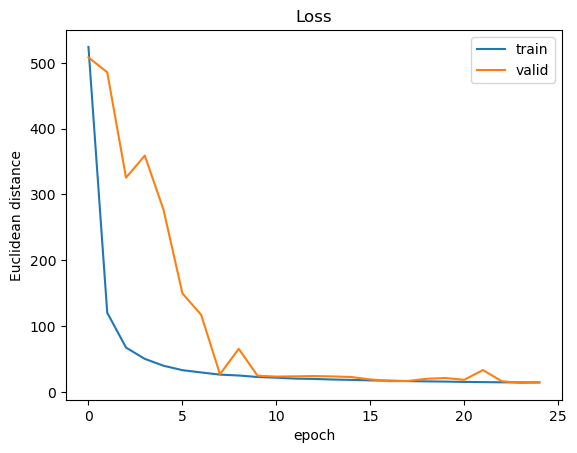

In [42]:
plt.plot(hist_df.index, hist_df['custom_euclidean'],'-',label='train')
plt.plot(hist_df.index, hist_df['val_custom_euclidean'],'-',label='valid')
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("Euclidean distance")
plt.title('Loss')
plt.show()

In [23]:
#img = Image.open('rectangles/test/0009.png')

In [24]:
#from skimage.io import imread
#imagedata=imread('rectangles/test/0009.png')/255.

In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels_test,
        directory='rectangles/test/',
        x_col='file_name',
        y_col=['x1','x2','x3','x4','y1','y2','y3','y4'],
        target_size=(480, 640),
        batch_size=4,
        class_mode='raw',
        shuffle=False,
        seed=42) 




Found 10000 validated image filenames.


In [26]:
STEP_SIZE_TEST=test_gen_flow.n//test_gen_flow.batch_size
test_gen_flow.reset()
pred=model.predict_generator(test_gen_flow,
steps=STEP_SIZE_TEST,
verbose=1)

C:\Users\Sergey.Polushkin\AppData\Local\Temp\ipykernel_3996\215360298.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_gen_flow,


2500/2500 [==============================] - 217s 86ms/step


In [47]:
labels_test.reset_index(inplace=True,drop=True)
labels_test

,x1,x2,x3,x4,y1,y2,y3,y4,file_name
0,40.406657,224.973475,194.566818,10.000000,193.941717,137.513978,38.058283,94.486022,33554.png
1,366.519190,513.074765,341.480810,194.925235,325.321279,150.663146,6.678721,181.336854,09428.png
2,244.811566,304.082430,69.270864,10.000000,332.133776,94.411323,35.866224,273.588677,00200.png
3,623.706722,633.179530,550.293278,540.820470,280.547915,99.795969,95.452085,276.204031,12448.png
4,440.262020,495.092316,415.737980,360.907684,470.000000,327.162195,296.700919,439.538724,39490.png
...,...,...,...,...,...,...,...,...,...
9995,360.152285,492.681004,331.847715,199.318996,315.482664,119.000759,10.517336,206.999241,28568.png
9996,51.051230,263.127252,214.948770,2.872748,217.211761,118.319088,15.000000,113.892673,25080.png
9997,157.549942,190.812313,43.262371,10.000000,470.000000,233.325932,212.589140,449.263208,18708.png
9998,45.005944,192.078984,157.073039,10.000000,338.126375,295.953860,173.873625,216.046140,15201.png


In [45]:
pred = pd.DataFrame(pred,columns=['x1','x2','x3','x4','y1','y2','y3','y4'])
pred

,x1,x2,x3,x4,y1,y2,y3,y4
0,42.114811,226.530060,196.813858,12.451908,192.092850,136.814117,38.342670,93.627037
1,366.344818,511.988892,340.917877,195.298965,323.256195,148.004227,6.958709,182.181000
2,242.389816,303.780457,71.017120,9.717337,331.248962,93.574020,35.106274,272.835205
3,615.379272,627.879700,544.562744,532.183777,277.525330,98.119049,93.406349,272.864319
4,441.696289,497.942047,417.655640,361.409790,467.514496,324.876068,295.047882,437.844055
...,...,...,...,...,...,...,...,...
9995,359.810516,490.618805,329.572052,198.833099,313.589447,117.985161,11.247738,206.860321
9996,53.630527,263.734131,216.335495,6.266562,215.061554,117.530968,15.830928,113.456993
9997,159.652237,194.223938,46.853718,12.295223,467.643463,230.767609,210.312088,447.239258
9998,47.235252,194.891129,159.450974,11.830664,336.876892,294.636780,173.984985,216.262131


In [49]:
pred_vs_actual = labels_test.join(pred,rsuffix='_pred')
pred_vs_actual

,x1,x2,x3,x4,y1,y2,y3,y4,file_name,x1_pred,x2_pred,x3_pred,x4_pred,y1_pred,y2_pred,y3_pred,y4_pred
0,40.406657,224.973475,194.566818,10.000000,193.941717,137.513978,38.058283,94.486022,33554.png,42.114811,226.530060,196.813858,12.451908,192.092850,136.814117,38.342670,93.627037
1,366.519190,513.074765,341.480810,194.925235,325.321279,150.663146,6.678721,181.336854,09428.png,366.344818,511.988892,340.917877,195.298965,323.256195,148.004227,6.958709,182.181000
2,244.811566,304.082430,69.270864,10.000000,332.133776,94.411323,35.866224,273.588677,00200.png,242.389816,303.780457,71.017120,9.717337,331.248962,93.574020,35.106274,272.835205
3,623.706722,633.179530,550.293278,540.820470,280.547915,99.795969,95.452085,276.204031,12448.png,615.379272,627.879700,544.562744,532.183777,277.525330,98.119049,93.406349,272.864319
4,440.262020,495.092316,415.737980,360.907684,470.000000,327.162195,296.700919,439.538724,39490.png,441.696289,497.942047,417.655640,361.409790,467.514496,324.876068,295.047882,437.844055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,360.152285,492.681004,331.847715,199.318996,315.482664,119.000759,10.517336,206.999241,28568.png,359.810516,490.618805,329.572052,198.833099,313.589447,117.985161,11.247738,206.860321
9996,51.051230,263.127252,214.948770,2.872748,217.211761,118.319088,15.000000,113.892673,25080.png,53.630527,263.734131,216.335495,6.266562,215.061554,117.530968,15.830928,113.456993
9997,157.549942,190.812313,43.262371,10.000000,470.000000,233.325932,212.589140,449.263208,18708.png,159.652237,194.223938,46.853718,12.295223,467.643463,230.767609,210.312088,447.239258
9998,45.005944,192.078984,157.073039,10.000000,338.126375,295.953860,173.873625,216.046140,15201.png,47.235252,194.891129,159.450974,11.830664,336.876892,294.636780,173.984985,216.262131


In [76]:
pred_vs_actual['l2'] = pred_vs_actual.apply(lambda x: np.linalg.norm(x[['x1','x2','x3','x4','y1','y2','y3','y4']].values-
                                                                  x[['x1_pred','x2_pred','x3_pred','x4_pred','y1_pred','y2_pred','y3_pred','y4_pred']].values), 
                                            axis=1)
pred_vs_actual['l2'].describe()

count    10000.000000
mean         5.955783
std         19.795059
min          0.805931
25%          3.560610
50%          4.641438
75%          5.990014
max        596.914595
Name: l2, dtype: float64

В среднем евклидово расстояние между реальным прямоугольником и прогнозом ~ 6. Но есть изображения, на которых нейросеть очень плохо распознала прямоугольники.

Посмотрим на гистограмму.

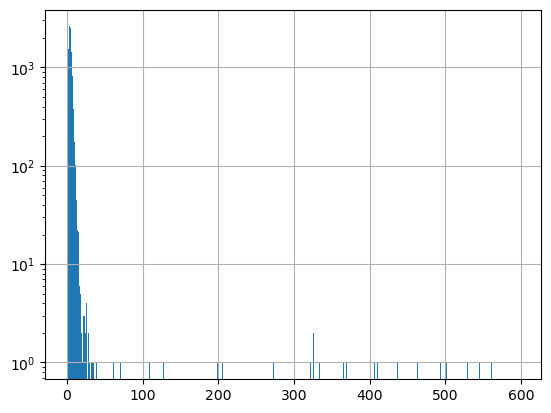

In [79]:
pred_vs_actual['l2'].hist(bins=500)
plt.yscale('log')

(0.0, 50.0)

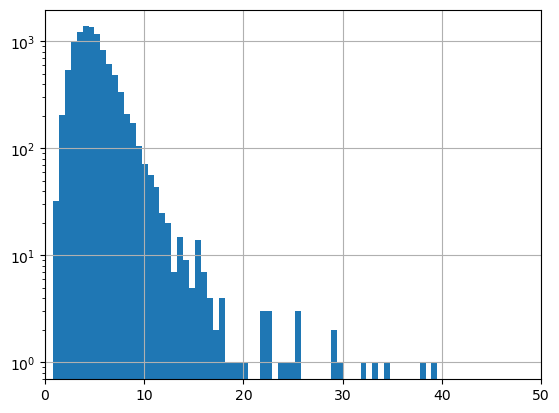

In [148]:
pred_vs_actual['l2'].hist(bins=1000)
plt.yscale('log')
plt.xlim(0,50)

Все расстояния сосредоточены недалеко от 0, но есть штучные изображения с большим евклидовым расстоянием, посмотрим на них поподробнее.

In [153]:
poor_predictions = pred_vs_actual[pred_vs_actual['l2']>50].sort_values('l2')
poor_predictions.head()

,x1,x2,x3,x4,y1,y2,y3,y4,file_name,x1_pred,x2_pred,x3_pred,x4_pred,y1_pred,y2_pred,y3_pred,y4_pred,l2
8385,11.849673,220.722356,218.872683,10.000000,470.000000,462.706005,409.738291,417.032286,16676.png,45.117870,237.108200,227.813980,35.936157,468.153015,456.809021,394.222656,405.612335,50.370982
3043,23.780858,273.628564,268.219142,18.371436,470.000000,461.275126,306.369548,315.094422,25885.png,53.384357,271.574738,256.098602,38.134155,436.581818,432.130524,295.418793,299.884552,61.118736
9842,620.634616,637.934221,461.365384,444.065779,337.871390,90.475506,78.128610,325.524494,44197.png,578.735474,595.907654,455.095001,437.895203,332.949310,112.085487,108.978249,329.803345,71.136426
6679,10.000000,196.000000,196.000000,10.000000,157.000000,157.000000,15.000000,15.000000,38311.png,57.641293,219.701096,207.359665,45.206905,180.040771,154.664627,60.847824,86.185890,109.113647
4881,153.912279,161.415671,17.503392,10.000000,234.894555,20.025528,15.000000,229.869028,29289.png,171.779297,215.739456,103.127930,59.265312,253.508545,64.845886,45.126850,233.521744,127.692016


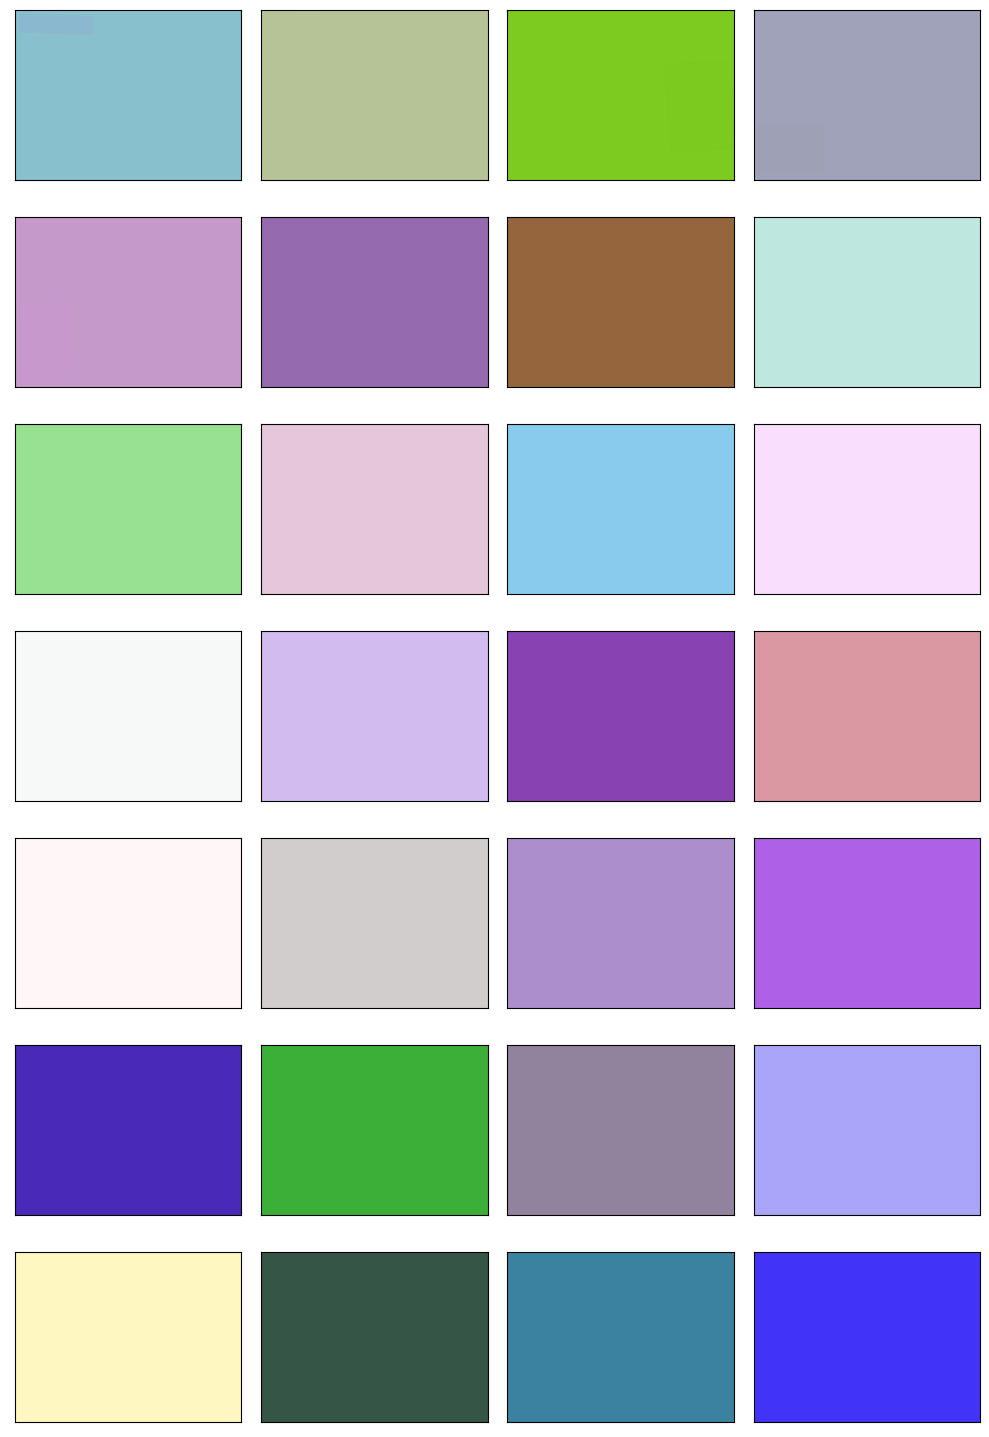

In [154]:
i=0
fig = plt.figure(figsize=(10,15))

for file in poor_predictions['file_name']:
    img=Image.open(f'rectangles/test/{file}')
    fig.add_subplot(7, 4, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    i+=1

В этих изображениях прямоугольник сливается с фоном. Нанесем исходный прямоугольник синим, а прогнозный красным.

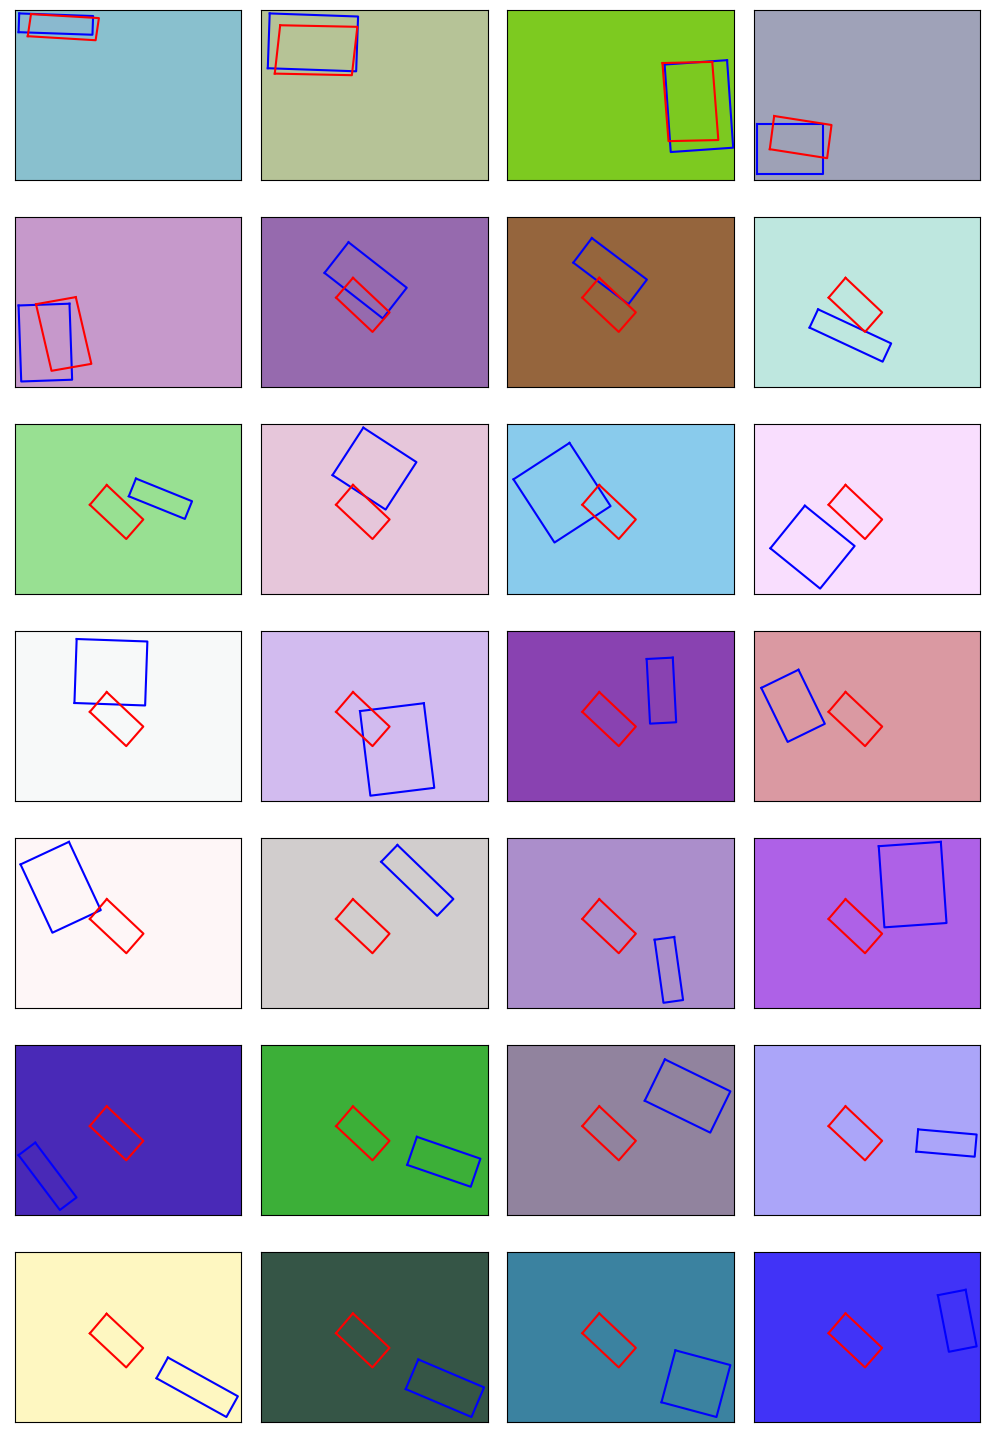

In [155]:
i=0
fig = plt.figure(figsize=(10,15))

for file in poor_predictions['file_name']:
    img=Image.open(f'rectangles/test/{file}')
    fig.add_subplot(7, 4, i+1)
    plt.imshow(img)
    x = poor_predictions[poor_predictions['file_name']==file][['x1','x2','x3','x4']].values[0]
    y = 480-poor_predictions[poor_predictions['file_name']==file][['y1','y2','y3','y4']].values[0]
    x_pred = poor_predictions[poor_predictions['file_name']==file][['x1_pred','x2_pred','x3_pred','x4_pred']].values[0]
    y_pred = 480-poor_predictions[poor_predictions['file_name']==file][['y1_pred','y2_pred','y3_pred','y4_pred']].values[0]
    plt.plot(x,y,'-',c='b')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'-b')
    plt.plot(x_pred,y_pred,'-',c='r')
    plt.plot([x_pred[0],x_pred[-1]],[y_pred[0],y_pred[-1]],'-r')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    i+=1


Там, где сеть не смогла отличить прямоугольники от фона, она делала прогноз средним прямоугольником, повернутым на 45 градусов.

Посмотрим на 15 лучших прогнозов.

In [144]:
best_predictions = pred_vs_actual.sort_values('l2').reset_index(drop=True).loc[:14]
best_predictions

,x1,x2,x3,x4,y1,y2,y3,y4,file_name,x1_pred,x2_pred,x3_pred,x4_pred,y1_pred,y2_pred,y3_pred,y4_pred,l2
0,15.618819,224.491502,218.872683,10.000000,259.097959,251.803964,90.902041,98.196036,20833.png,16.076996,224.425797,218.617050,10.407602,259.000824,252.094574,91.229019,98.141350,0.805931
1,254.039845,388.390133,275.960155,141.609867,358.390133,224.039845,111.609867,245.960155,32049.png,254.791946,388.883179,275.842682,141.795151,358.185852,224.122711,111.811295,245.881332,0.975840
2,118.811082,341.573257,307.188918,84.426743,374.780680,280.223747,199.219320,293.776253,01419.png,119.295708,341.184875,306.839050,84.975334,374.495514,279.974518,198.974823,293.502075,1.042808
3,241.902183,362.134969,160.097817,39.865031,337.448355,120.542667,8.551645,225.457333,06362.png,242.042313,362.219482,159.750900,39.615234,336.982513,120.373085,9.247600,225.899796,1.065561
4,67.160519,248.761548,238.839481,57.238452,352.172139,316.872475,265.827861,301.127525,46079.png,67.370567,249.619095,239.353455,57.221523,351.882935,316.705719,266.043213,301.259766,1.104207
5,108.365746,231.136011,173.634254,50.863989,367.126163,204.204519,160.873837,323.795481,32379.png,108.396973,231.053894,173.083908,50.439636,366.674591,203.606735,161.075516,324.175262,1.112135
6,57.944790,254.042176,238.055210,41.957824,331.991599,275.761579,220.008401,276.238421,11733.png,58.597408,254.668213,237.701767,41.739796,331.791595,275.314789,219.891693,276.443481,1.133836
7,117.037065,231.411263,160.962935,46.588737,351.935249,175.814430,130.064751,306.185570,20959.png,117.612816,231.098190,160.665115,47.217628,351.466827,175.512146,130.341812,306.270416,1.143879
8,69.229379,226.090995,166.861616,10.000000,322.413104,228.161136,129.586896,223.838864,38310.png,69.341934,226.042526,166.714249,10.074826,321.503693,227.760376,130.127335,223.877090,1.150437
9,221.722191,281.960744,108.277809,48.039256,321.453828,79.850192,36.546172,278.149808,20454.png,222.050156,282.829041,108.164238,47.378311,321.651947,79.820061,36.492104,278.300110,1.173423


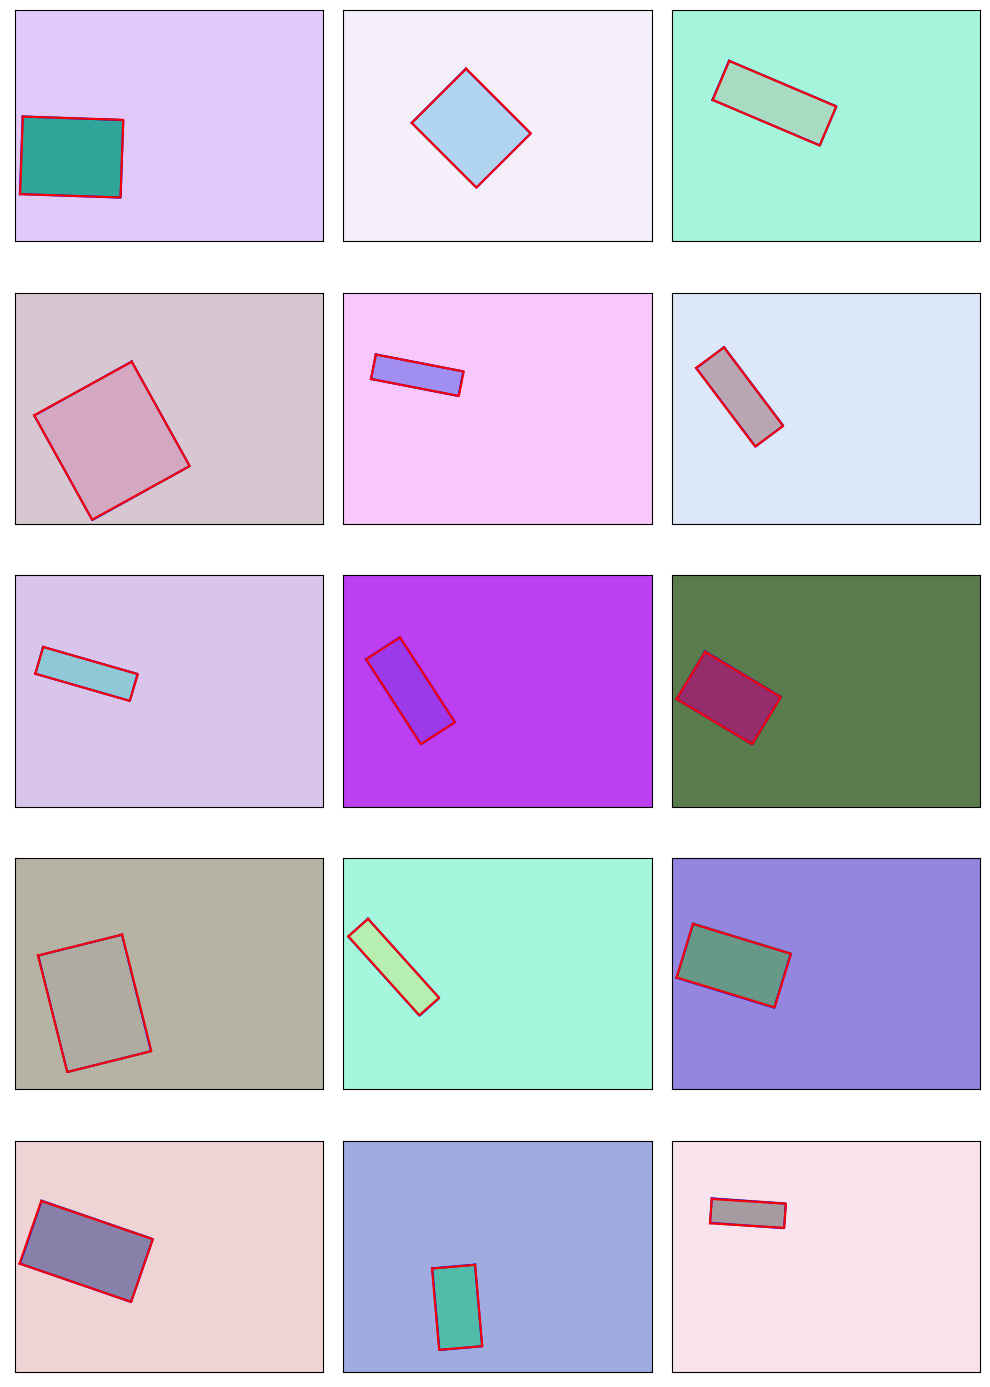

In [145]:
i=0
fig = plt.figure(figsize=(10,15))

for file in best_predictions['file_name']:
    img=Image.open(f'rectangles/test/{file}')
    fig.add_subplot(5, 3, i+1)
    plt.imshow(img)
    x = best_predictions[best_predictions['file_name']==file][['x1','x2','x3','x4']].values[0]
    y = 480-best_predictions[best_predictions['file_name']==file][['y1','y2','y3','y4']].values[0]
    x_pred = best_predictions[best_predictions['file_name']==file][['x1_pred','x2_pred','x3_pred','x4_pred']].values[0]
    y_pred = 480-best_predictions[best_predictions['file_name']==file][['y1_pred','y2_pred','y3_pred','y4_pred']].values[0]
    plt.plot(x,y,'-',c='b')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'-b')
    plt.plot(x_pred,y_pred,'-',c='r')
    plt.plot([x_pred[0],x_pred[-1]],[y_pred[0],y_pred[-1]],'-r')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    i+=1


# Best epoch

Наилучший результат был в 24 эпохе.

In [172]:
model.load_weights(f'checkpoints/resnet50_24/variables/variables')

In [173]:
pred=model.predict_generator(test_gen_flow,
steps=STEP_SIZE_TEST,
verbose=1)

C:\Users\Sergey.Polushkin\AppData\Local\Temp\ipykernel_3996\1159241392.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_gen_flow,


2500/2500 [==============================] - 215s 86ms/step


In [174]:
pred = pd.DataFrame(pred,columns=['x1','x2','x3','x4','y1','y2','y3','y4'])
pred

,x1,x2,x3,x4,y1,y2,y3,y4
0,39.081463,221.633270,192.071091,9.505999,193.308487,137.032349,38.412048,94.580208
1,365.711182,513.391174,340.945129,193.182663,323.068573,148.145233,6.073375,180.852707
2,241.767929,301.968170,67.868477,7.689731,329.395905,93.242546,36.279816,272.436279
3,621.655273,630.826050,548.999084,539.824707,282.386749,103.853493,99.124214,277.451599
4,440.344147,494.865601,414.999603,360.420624,468.117554,325.334503,294.509827,437.318542
...,...,...,...,...,...,...,...,...
9995,358.469788,491.250122,330.382782,197.568939,313.738495,118.758034,11.324146,206.184906
9996,48.391884,258.071259,212.044037,2.312508,215.794342,117.387558,14.705896,113.084610
9997,158.996613,191.414017,43.181393,10.719346,467.925995,231.069504,210.859726,447.671783
9998,43.716202,190.556335,155.867386,8.987097,337.641693,295.900513,174.262238,216.011108


In [175]:
pred_vs_actual = labels_test.join(pred,rsuffix='_pred')
pred_vs_actual

,x1,x2,x3,x4,y1,y2,y3,y4,file_name,x1_pred,x2_pred,x3_pred,x4_pred,y1_pred,y2_pred,y3_pred,y4_pred
0,40.406657,224.973475,194.566818,10.000000,193.941717,137.513978,38.058283,94.486022,33554.png,39.081463,221.633270,192.071091,9.505999,193.308487,137.032349,38.412048,94.580208
1,366.519190,513.074765,341.480810,194.925235,325.321279,150.663146,6.678721,181.336854,09428.png,365.711182,513.391174,340.945129,193.182663,323.068573,148.145233,6.073375,180.852707
2,244.811566,304.082430,69.270864,10.000000,332.133776,94.411323,35.866224,273.588677,00200.png,241.767929,301.968170,67.868477,7.689731,329.395905,93.242546,36.279816,272.436279
3,623.706722,633.179530,550.293278,540.820470,280.547915,99.795969,95.452085,276.204031,12448.png,621.655273,630.826050,548.999084,539.824707,282.386749,103.853493,99.124214,277.451599
4,440.262020,495.092316,415.737980,360.907684,470.000000,327.162195,296.700919,439.538724,39490.png,440.344147,494.865601,414.999603,360.420624,468.117554,325.334503,294.509827,437.318542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,360.152285,492.681004,331.847715,199.318996,315.482664,119.000759,10.517336,206.999241,28568.png,358.469788,491.250122,330.382782,197.568939,313.738495,118.758034,11.324146,206.184906
9996,51.051230,263.127252,214.948770,2.872748,217.211761,118.319088,15.000000,113.892673,25080.png,48.391884,258.071259,212.044037,2.312508,215.794342,117.387558,14.705896,113.084610
9997,157.549942,190.812313,43.262371,10.000000,470.000000,233.325932,212.589140,449.263208,18708.png,158.996613,191.414017,43.181393,10.719346,467.925995,231.069504,210.859726,447.671783
9998,45.005944,192.078984,157.073039,10.000000,338.126375,295.953860,173.873625,216.046140,15201.png,43.716202,190.556335,155.867386,8.987097,337.641693,295.900513,174.262238,216.011108


In [176]:
pred_vs_actual['l2'] = pred_vs_actual.apply(lambda x: np.linalg.norm(x[['x1','x2','x3','x4','y1','y2','y3','y4']].values-
                                                                  x[['x1_pred','x2_pred','x3_pred','x4_pred','y1_pred','y2_pred','y3_pred','y4_pred']].values), 
                                            axis=1)
pred_vs_actual['l2'].describe()

count    10000.000000
mean         5.423574
std         19.755865
min          0.502679
25%          2.955469
50%          3.958131
75%          5.402133
max        593.747751
Name: l2, dtype: float64

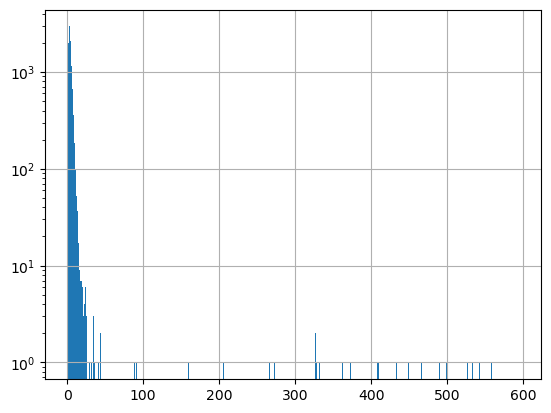

In [177]:
pred_vs_actual['l2'].hist(bins=500)
plt.yscale('log')

(0.0, 50.0)

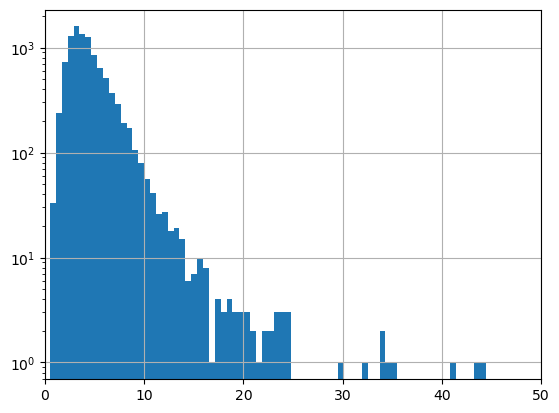

In [178]:
pred_vs_actual['l2'].hist(bins=1000)
plt.yscale('log')
plt.xlim(0,50)

In [180]:
poor_predictions = pred_vs_actual[pred_vs_actual['l2']>50].sort_values('l2')
poor_predictions.head()

,x1,x2,x3,x4,y1,y2,y3,y4,file_name,x1_pred,x2_pred,x3_pred,x4_pred,y1_pred,y2_pred,y3_pred,y4_pred,l2
2462,98.871465,312.838871,311.128535,97.161129,346.859945,343.125130,245.140055,248.874870,20051.png,125.965210,306.818573,272.327545,91.233932,374.397217,336.165314,233.262894,271.320007,61.339670
6679,10.000000,196.000000,196.000000,10.000000,157.000000,157.000000,15.000000,15.000000,38311.png,43.023369,212.875183,201.634354,31.731535,187.222397,168.547134,52.406624,70.989311,86.371919
3325,591.054674,607.614265,520.945326,504.385735,226.429771,37.152778,29.570229,218.847222,02981.png,576.575195,576.512878,463.268646,463.231995,250.739624,33.207840,35.334175,252.411896,89.238575
4881,153.912279,161.415671,17.503392,10.000000,234.894555,20.025528,15.000000,229.869028,29289.png,170.995316,201.093140,73.818497,43.731667,262.900604,50.183510,31.270235,243.548737,91.219766
4638,246.514257,411.208505,343.485743,178.791495,408.677216,280.003967,193.322784,321.996033,26566.png,260.948425,364.066956,316.383148,213.682816,307.434631,210.452866,155.874344,251.969635,160.549445


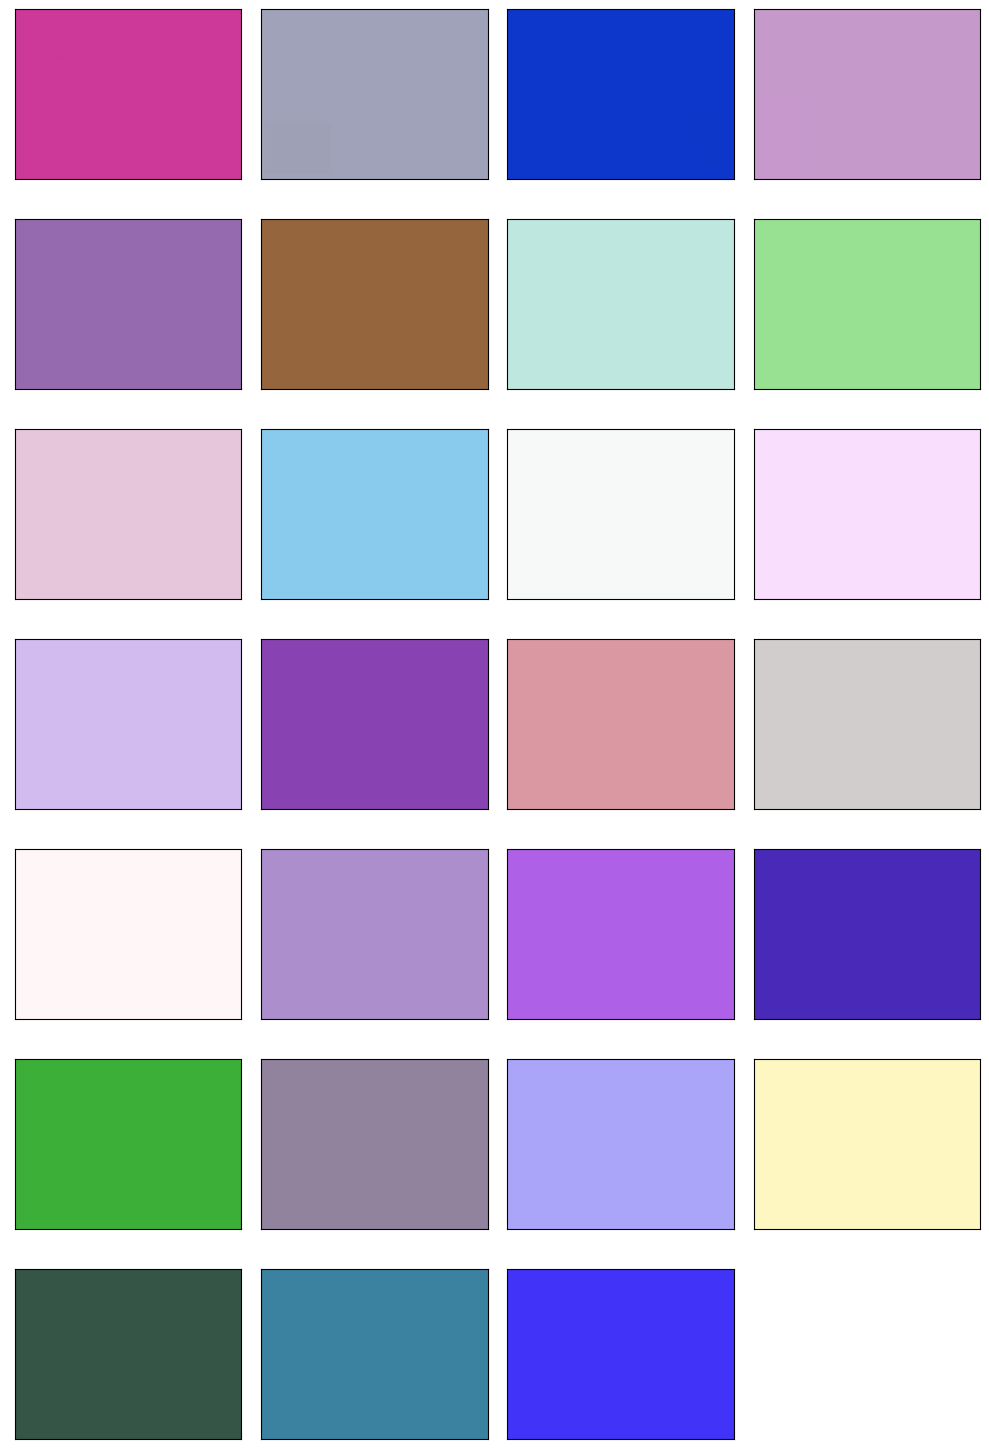

In [181]:
i=0
fig = plt.figure(figsize=(10,15))

for file in poor_predictions['file_name']:
    img=Image.open(f'rectangles/test/{file}')
    fig.add_subplot(7, 4, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    i+=1

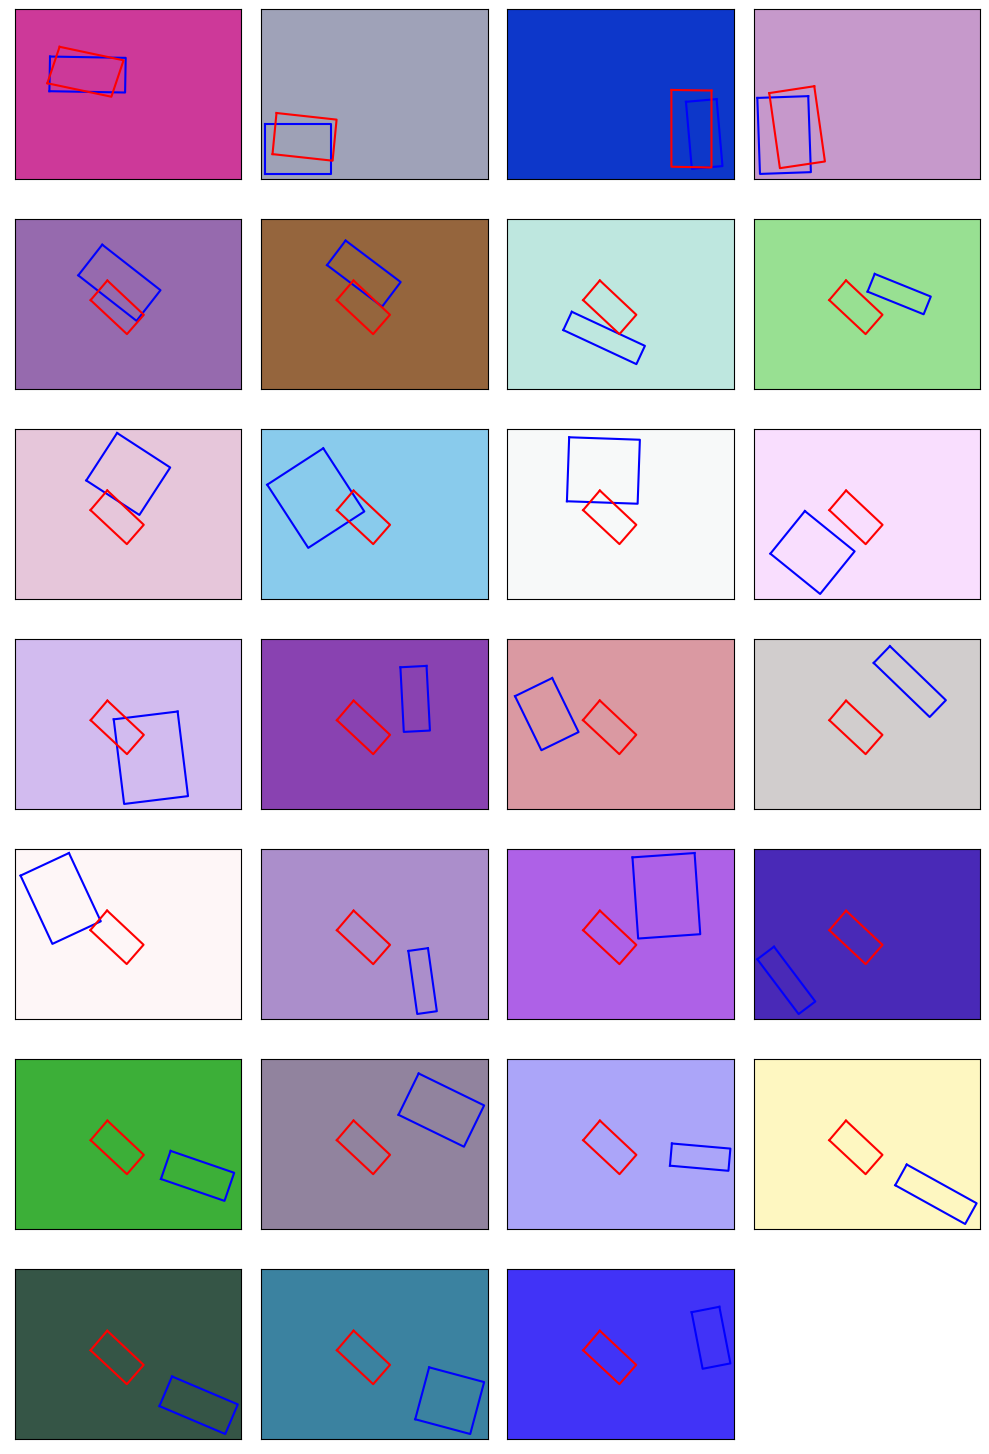

In [182]:
i=0
fig = plt.figure(figsize=(10,15))

for file in poor_predictions['file_name']:
    img=Image.open(f'rectangles/test/{file}')
    fig.add_subplot(7, 4, i+1)
    plt.imshow(img)
    x = poor_predictions[poor_predictions['file_name']==file][['x1','x2','x3','x4']].values[0]
    y = 480-poor_predictions[poor_predictions['file_name']==file][['y1','y2','y3','y4']].values[0]
    x_pred = poor_predictions[poor_predictions['file_name']==file][['x1_pred','x2_pred','x3_pred','x4_pred']].values[0]
    y_pred = 480-poor_predictions[poor_predictions['file_name']==file][['y1_pred','y2_pred','y3_pred','y4_pred']].values[0]
    plt.plot(x,y,'-',c='b')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'-b')
    plt.plot(x_pred,y_pred,'-',c='r')
    plt.plot([x_pred[0],x_pred[-1]],[y_pred[0],y_pred[-1]],'-r')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    i+=1


# 10-ая эпоха

In [183]:
model.load_weights(f'checkpoints/resnet50_10/variables/variables')

In [184]:
pred=model.predict_generator(test_gen_flow,
steps=STEP_SIZE_TEST,
verbose=1)

C:\Users\Sergey.Polushkin\AppData\Local\Temp\ipykernel_3996\1159241392.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_gen_flow,


2500/2500 [==============================] - 215s 86ms/step


In [185]:
pred = pd.DataFrame(pred,columns=['x1','x2','x3','x4','y1','y2','y3','y4'])
pred

,x1,x2,x3,x4,y1,y2,y3,y4
0,37.617420,218.614899,191.416718,10.205256,188.414642,137.324692,40.926868,92.055099
1,362.573486,510.458801,341.177185,193.218750,320.320465,146.640182,7.900943,181.647659
2,244.759521,301.689972,63.897869,6.879718,333.753052,92.117149,35.534229,277.354706
3,616.456177,624.085999,543.182068,535.145935,274.595764,93.322014,91.945137,273.290833
4,438.958435,496.237915,420.324005,362.654327,470.197662,330.099731,300.507599,440.865601
...,...,...,...,...,...,...,...,...
9995,356.950043,489.871460,330.364716,197.335815,314.274170,117.795547,11.249847,207.882080
9996,49.213078,257.224701,211.674225,3.364346,213.680008,120.871246,18.193855,111.014160
9997,154.395096,184.640732,35.176998,4.582485,471.835968,234.304977,215.534378,453.421051
9998,46.049564,189.130569,157.194290,13.791989,336.024841,298.099762,176.373734,214.494400


In [186]:
pred_vs_actual = labels_test.join(pred,rsuffix='_pred')
pred_vs_actual

,x1,x2,x3,x4,y1,y2,y3,y4,file_name,x1_pred,x2_pred,x3_pred,x4_pred,y1_pred,y2_pred,y3_pred,y4_pred
0,40.406657,224.973475,194.566818,10.000000,193.941717,137.513978,38.058283,94.486022,33554.png,37.617420,218.614899,191.416718,10.205256,188.414642,137.324692,40.926868,92.055099
1,366.519190,513.074765,341.480810,194.925235,325.321279,150.663146,6.678721,181.336854,09428.png,362.573486,510.458801,341.177185,193.218750,320.320465,146.640182,7.900943,181.647659
2,244.811566,304.082430,69.270864,10.000000,332.133776,94.411323,35.866224,273.588677,00200.png,244.759521,301.689972,63.897869,6.879718,333.753052,92.117149,35.534229,277.354706
3,623.706722,633.179530,550.293278,540.820470,280.547915,99.795969,95.452085,276.204031,12448.png,616.456177,624.085999,543.182068,535.145935,274.595764,93.322014,91.945137,273.290833
4,440.262020,495.092316,415.737980,360.907684,470.000000,327.162195,296.700919,439.538724,39490.png,438.958435,496.237915,420.324005,362.654327,470.197662,330.099731,300.507599,440.865601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,360.152285,492.681004,331.847715,199.318996,315.482664,119.000759,10.517336,206.999241,28568.png,356.950043,489.871460,330.364716,197.335815,314.274170,117.795547,11.249847,207.882080
9996,51.051230,263.127252,214.948770,2.872748,217.211761,118.319088,15.000000,113.892673,25080.png,49.213078,257.224701,211.674225,3.364346,213.680008,120.871246,18.193855,111.014160
9997,157.549942,190.812313,43.262371,10.000000,470.000000,233.325932,212.589140,449.263208,18708.png,154.395096,184.640732,35.176998,4.582485,471.835968,234.304977,215.534378,453.421051
9998,45.005944,192.078984,157.073039,10.000000,338.126375,295.953860,173.873625,216.046140,15201.png,46.049564,189.130569,157.194290,13.791989,336.024841,298.099762,176.373734,214.494400


In [187]:
pred_vs_actual['l2'] = pred_vs_actual.apply(lambda x: np.linalg.norm(x[['x1','x2','x3','x4','y1','y2','y3','y4']].values-
                                                                  x[['x1_pred','x2_pred','x3_pred','x4_pred','y1_pred','y2_pred','y3_pred','y4_pred']].values), 
                                            axis=1)
pred_vs_actual['l2'].describe()

count    10000.000000
mean        10.703563
std         21.294985
min          1.449005
25%          7.031250
50%          9.029071
75%         11.519685
max        642.987960
Name: l2, dtype: float64

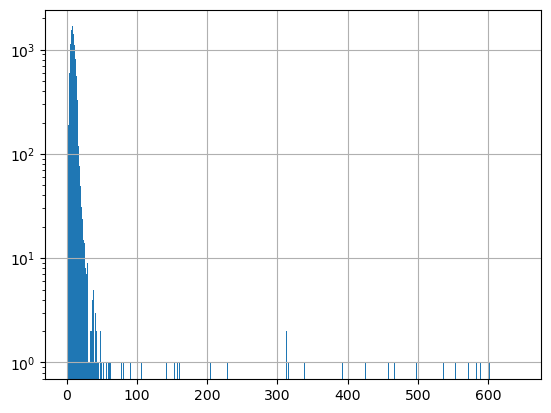

In [188]:
pred_vs_actual['l2'].hist(bins=500)
plt.yscale('log')

(0.0, 50.0)

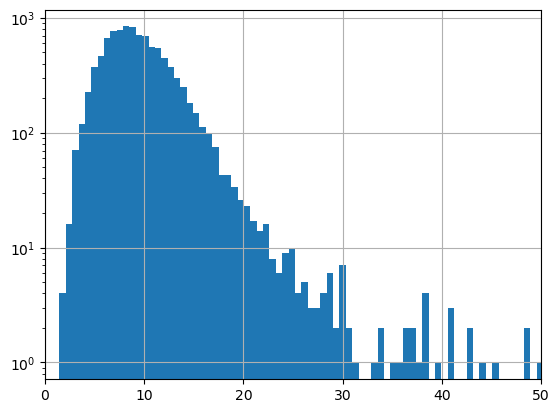

In [189]:
pred_vs_actual['l2'].hist(bins=1000)
plt.yscale('log')
plt.xlim(0,50)

In [193]:
poor_predictions = pred_vs_actual[pred_vs_actual['l2']>50].sort_values('l2')
poor_predictions.shape

(40, 18)

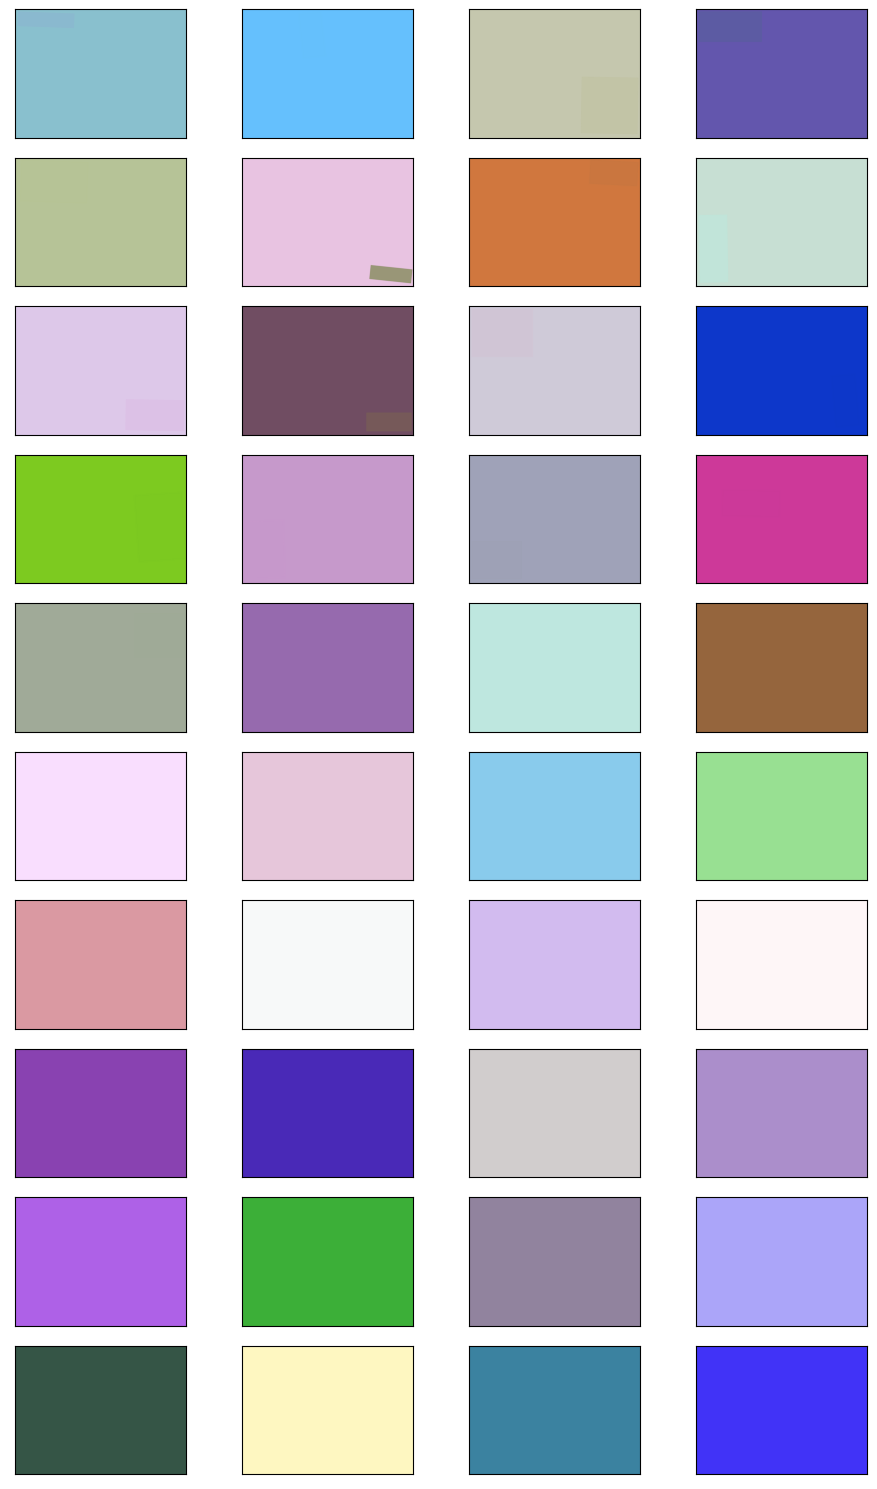

In [195]:
i=0
fig = plt.figure(figsize=(10,15))

for file in poor_predictions['file_name']:
    img=Image.open(f'rectangles/test/{file}')
    fig.add_subplot(10, 4, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    i+=1

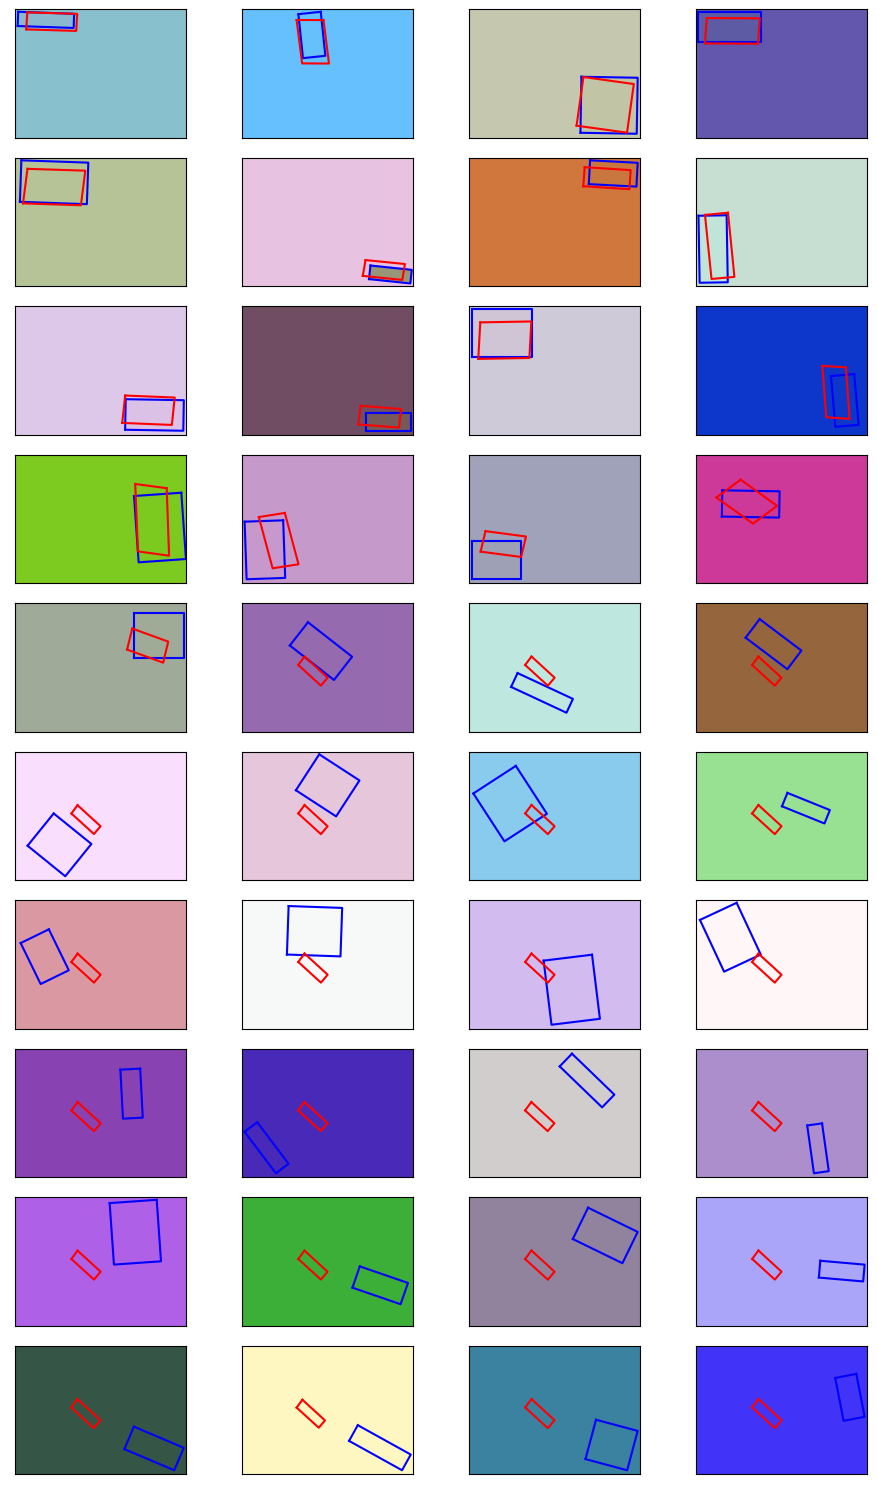

In [196]:
i=0
fig = plt.figure(figsize=(10,15))

for file in poor_predictions['file_name']:
    img=Image.open(f'rectangles/test/{file}')
    fig.add_subplot(10, 4, i+1)
    plt.imshow(img)
    x = poor_predictions[poor_predictions['file_name']==file][['x1','x2','x3','x4']].values[0]
    y = 480-poor_predictions[poor_predictions['file_name']==file][['y1','y2','y3','y4']].values[0]
    x_pred = poor_predictions[poor_predictions['file_name']==file][['x1_pred','x2_pred','x3_pred','x4_pred']].values[0]
    y_pred = 480-poor_predictions[poor_predictions['file_name']==file][['y1_pred','y2_pred','y3_pred','y4_pred']].values[0]
    plt.plot(x,y,'-',c='b')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'-b')
    plt.plot(x_pred,y_pred,'-',c='r')
    plt.plot([x_pred[0],x_pred[-1]],[y_pred[0],y_pred[-1]],'-r')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    i+=1
